# Machine Problem  
## Training a Support Vector Machine for Student Grade Prediction
Nathaniel Cruel and Renzo Virtucio  
Department of Computer Science, University of the Philippines Diliman  
CS 180: Artificial Intelligence  
Professor Carlo Raquel  
June 15, 2021
***

## Introduction to the Problem
Academic performance has long been a top priority of academic institutions and its constituents, which includes the faculty and the students, as this is used as one of the measurements of their success. Intuitively, a student’s academic performance is often attributed to the similarly academic parameters such as the total number of hours spent on studying for a written assessment, the researchers wanted to determine if there exists an underlying pattern, which can be identified by machine learning, in the relationship between a student’s academic performance and other, possibly inconspicuous, factors found in their demographics, academic profile and social profile.
## Rationale
A student’s experience in school cannot be limited only to their academics, so plenty of other factors may affect their academic performance. Since student demographics, academic profile and social profile are readily available as these are collected at the time of enrollment, evaluating these data may provide valuable insight into how academic institutions and their constituents may be able to address the concern of improving or addressing a student’s academic performance.
## Objective
The objective of this project is to train a Support Vector Machine (SVM) on the Student Performance dataset so that it can predict the final grades of high school students in Mathematics by analyzing 33 attributes describing the students’ demographics and their academic and social profiles.

## Methodology
This project used a Principal Component Analysis (PCA) and Support Vector Machine (SVM) in a pipeline to predict the classification over the Student Math Performance dataset by Paulo Cortez and Alice Silva published in the UCI Machine Learning Repository using attributes describing the students’ demographics and their academic and social profiles. The dataset was collected through school reports and questionnaires. The complete list of attributes are as follows:

1. school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2. sex - student's sex (binary: "F" - female or "M" - male)
3. age - student's age (numeric: from 15 to 22)
4. address - student's home address type (binary: "U" - urban or "R" - rural)
5. famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6. Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7. Medu - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8. Fedu - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9. Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
10. Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
11. reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
12. guardian - student's guardian (nominal: "mother", "father" or "other")
13. traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
14. studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
15. failures - number of past class failures (numeric: n if 1<=n<3, else 4)
16. schoolsup - extra educational support (binary: yes or no)
17. famsup - family educational support (binary: yes or no)
18. paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
19. activities - extra-curricular activities (binary: yes or no)
20. nursery - attended nursery school (binary: yes or no)
21. higher - wants to take higher education (binary: yes or no)
22. internet - Internet access at home (binary: yes or no)
23. romantic - with a romantic relationship (binary: yes or no)
24. famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
25. freetime - free time after school (numeric: from 1 - very low to 5 - very high)
26. goout - going out with friends (numeric: from 1 - very low to 5 - very high)
27. Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
28. Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. health - current health status (numeric: from 1 - very bad to 5 - very good)
30. absences - number of school absences (numeric: from 0 to 93)
31. G1 - first period grade (numeric: from 0 to 20)
32. G2 - second period grade (numeric: from 0 to 20)
33. G3 - final grade (numeric: from 0 to 20, output target)

This dataset can be accessed [here](https://archive.ics.uci.edu/ml/datasets/student+performance).

## Data and Analysis
### Training the Support Vector Machine Classifier

The spreedsheet student-mat.csv is read. The dataset is inputted into the variable students_math. The contents of the dataset can be seen below.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

# Create dataframe
students_math = pd.read_csv('student-mat.csv', delimiter=';', header=0)
print("Table 1. Initial students_math dataframe")
display(students_math)

Table 1. Initial students_math dataframe


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


The dataset undergoes preprocessing before analysis. First, binary attributes are encoded to binary categorical data (0 and 1) while nominal attributes are encoded by adding dummy columns for the possible values of each attribute.

Furthermore, a new column/attribute called Quality is added to the dataset. The value of this attribute depends on the value of attribute G3. If G3 is GREATER THAN OR EQUAL TO 12 (60% of 20, the highest possible value of G3), then QUALITY is set to 1 (HIGH grade). If G3 is greater than 0 but less than 12, then QUALITY is 0 (LOW grade).

This binary attribute will serve as the target output in the analysis, as it is ideal for the Support Vector Machine (SVM) algorithm to be used.

In [2]:
## PREPROCESSING ##
# Encoding binary attributes
students_math.school = students_math.school.map({"GP":0, "MS":1})
students_math.sex = students_math.sex.map({"F":0, "M":1})
students_math.address = students_math.address.map({"U":0, "R":1})
students_math.famsize = students_math.famsize.map({"LE3":0, "GT3":1})
students_math.Pstatus = students_math.Pstatus.map({"T":0, "A":1})
students_math.schoolsup = students_math.schoolsup.map({"yes":0, "no":1})
students_math.famsup = students_math.famsup.map({"yes":0, "no":1})
students_math.paid = students_math.paid.map({"yes":0, "no":1})
students_math.activities = students_math.activities.map({"yes":0, "no":1})
students_math.nursery = students_math.nursery.map({"yes":0, "no":1})
students_math.higher = students_math.higher.map({"yes":0, "no":1})
students_math.internet = students_math.internet.map({"yes":0, "no":1})
students_math.romantic = students_math.romantic.map({"yes":0, "no":1})

# Encoding nominal attributes
job_types = ["teacher", "health", "services", "at_home", "other"]
reason_types = ["home", "reputation", "course", "other"]
guardian_types = ["mother", "father", "other"]
Mjob_dum = pd.get_dummies(students_math['Mjob'], prefix='Mjob')
Fjob_dum = pd.get_dummies(students_math['Fjob'], prefix='Fjob')
reason_dum = pd.get_dummies(students_math['reason'], prefix='reason')
guardian_dum = pd.get_dummies(students_math['guardian'], prefix='guardian')

students_math = pd.concat([students_math, Mjob_dum, Fjob_dum, reason_dum, guardian_dum], axis=1)
students_math.drop(['Mjob', 'Fjob', 'reason', 'guardian'], axis=1, inplace=True)
students_math

# Add a column describing if G3 (final grade) is high or low
# High = 12-20 (60% of 20 and above)
# Low = 0-11 (below 60% of 20)
students_math["quality"] = (students_math.G3 >= 12).map({True: 1, False: 0})
print("Table 2. Preprocessed students_math dataframe")
display(students_math)

Table 2. Preprocessed students_math dataframe


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,quality
0,0,0,18,0,1,1,4,4,2,2,...,0,1,1,0,0,0,0,1,0,0
1,0,0,17,0,1,0,1,1,1,2,...,0,0,1,0,0,0,1,0,0,0
2,0,0,15,0,0,0,1,1,1,2,...,0,0,0,0,1,0,0,1,0,0
3,0,0,15,0,1,0,4,2,1,3,...,1,0,0,1,0,0,0,1,0,1
4,0,0,16,0,1,0,3,3,1,2,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1,1,20,0,0,1,2,2,1,2,...,1,0,1,0,0,0,0,0,1,0
391,1,1,17,0,0,0,3,1,2,1,...,1,0,1,0,0,0,0,1,0,1
392,1,1,21,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,0,1,0
393,1,1,18,1,0,0,3,2,3,1,...,0,0,1,0,0,0,0,1,0,0


To examine the correlation levels of the attributes with respect to one another and with respect to the target variable, Quality, a correlation heatmap is plotted.

Figure 1. Correlation Matrix Heatmap of Student Performance Dataset


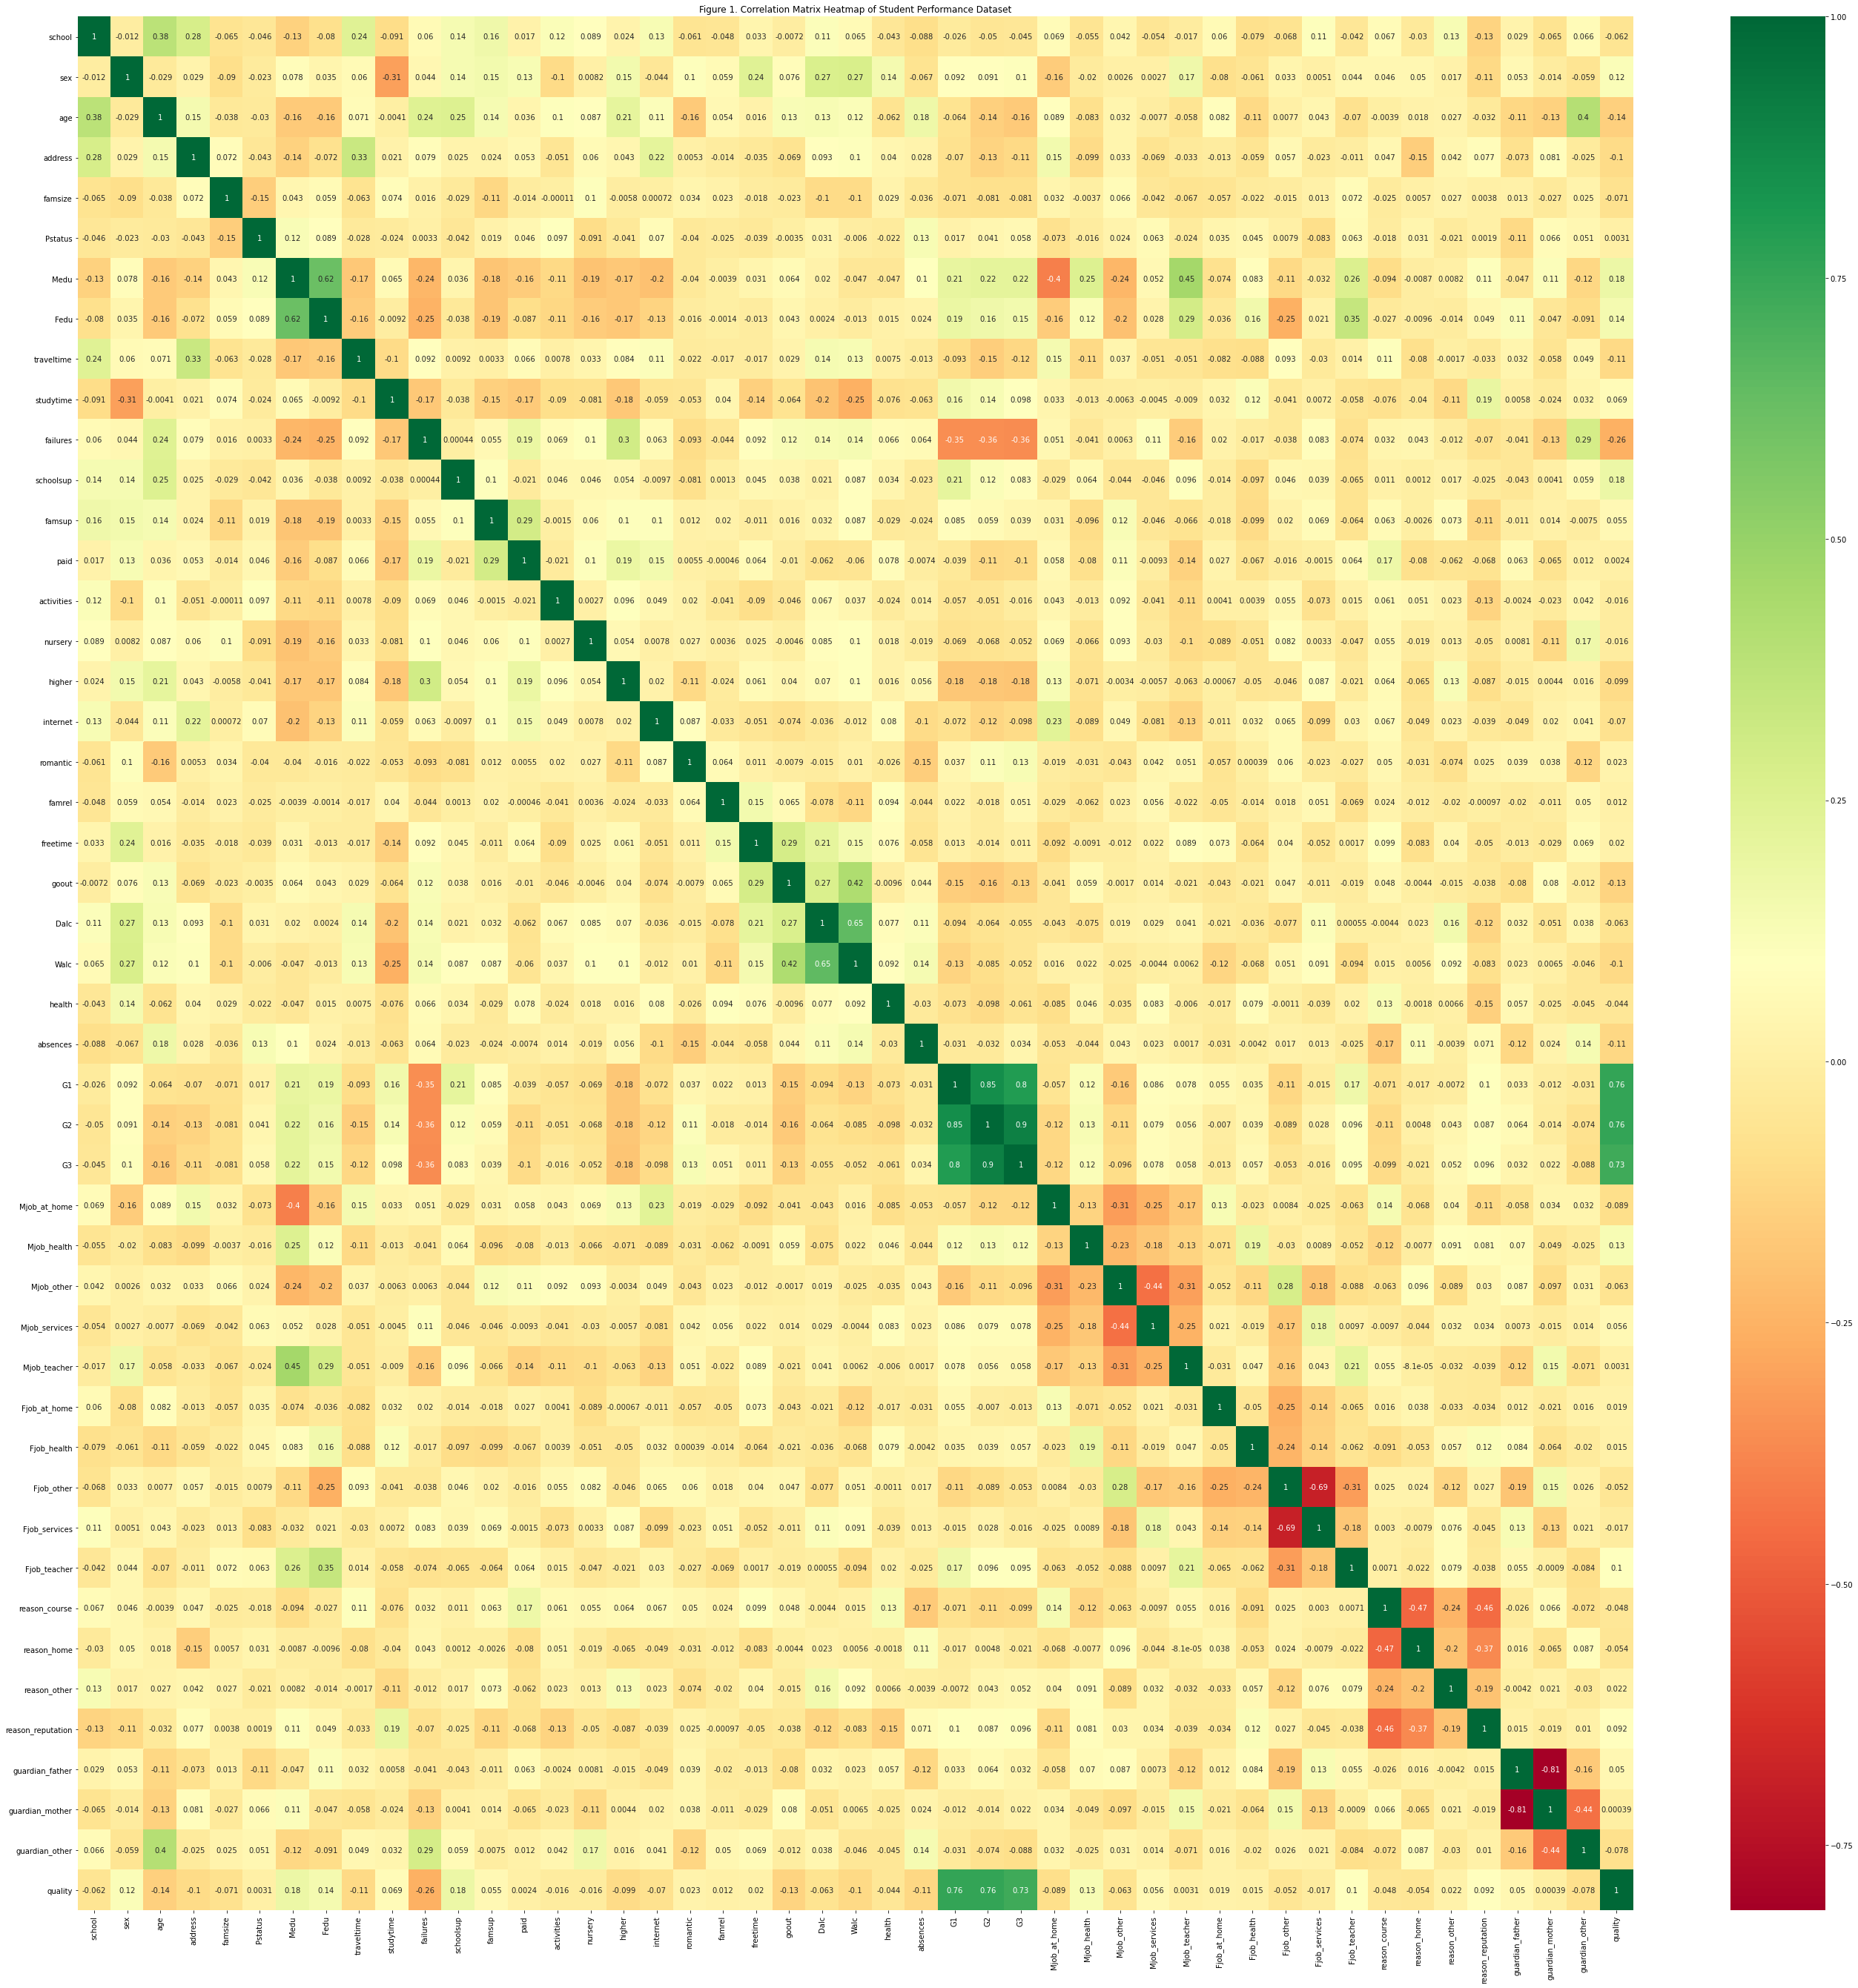

In [3]:
#Determine correlation per two variables
corrmat = students_math.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(47,47))
plt.title("Figure 1. Correlation Matrix Heatmap of Student Performance Dataset")

# Plot heat map
print("Figure 1. Correlation Matrix Heatmap of Student Performance Dataset")
g=sns.heatmap(students_math[top_corr_features].corr(),annot=True,cmap="RdYlGn")

The correlation heatmap above shows that the attributes G1 (grade in 1st period), G2 (grade in 2nd period), are highly correlated to G3 and the target output, Quality.

In [4]:
# Define X and y for testing and training
y = students_math['quality']
# Drop G3 and the target variable, Quality
X = students_math.drop(['quality', 'G3'], axis=1)  
print(X.shape, y.shape)

(395, 45) (395,)


We set the target column, y, to be the 'quality' column of the students_math dataframe, and set the data, X, to be the students_math dataframe without the columns 'quality' and 'G3'. 'G3' is removed since it is already interpreted by the target variable 'quality'.

In [5]:
# Compute for the Variance Inflation Factor of each variable to identify
# multicollinearity
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# Compute for the Variance Inflation Factor of each variable
print("Table 3. Variance Inflation Factor of variables of dataframe described in Table 2")
calculate_vif(X)

Table 3. Variance Inflation Factor of variables of dataframe described in Table 2
<ipython-input-5-9e8800a11dd2>:10: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1/(1-r_squared),2)


,Var,Vif
44,guardian_other,inf
37,Fjob_teacher,inf
28,Mjob_at_home,inf
29,Mjob_health,inf
30,Mjob_other,inf
31,Mjob_services,inf
32,Mjob_teacher,inf
33,Fjob_at_home,inf
34,Fjob_health,inf
35,Fjob_other,inf


We observe that the variance inflation factor of multiple variables are extremely high, some approaching infinity. Thus, there is a presence of multicollinearity which poses a problem as this undermines the statistical significance of supposedly independent variables.  

To address multicollinearity within the data, we utilize Principal Component Analysis which employs matrix factorization to reduce the dimensionality of data into lower space that still contains most of the information in the larger set.

Figure 2. Number of components vs. Cumulative explained variance of dataframe described in Table 2


Text(0, 0.5, 'cumulative explained variance')

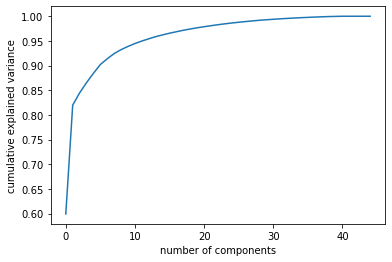

In [6]:
# To address multicollinearity, we utilize Principal Component Analysis.
# Determine the optimal number of components based on the cumulative
# explained variance.
pca = PCA().fit(X)
print("Figure 2. Number of components vs. Cumulative explained variance of dataframe described in Table 2")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We observe that at 10 components, the cumulative explained variance already reaches 0.90. Thus, we decided to use 15 components.

In [7]:
# Standardize the data
X = StandardScaler().fit_transform(X)
# PCA Projection
pca = PCA(n_components=15)  
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents)

# Display new dataframe
print("Table 4. students_math dataframe after PCA")
display(X)
# Compute for the Variance Inflation Factor of each variable
print("Table 5. Variance Inflation Factor of variables of students_math after PCA")
calculate_vif(X)  

Table 4. students_math dataframe after PCA


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.284742,-0.647852,-1.109581,1.897002,-3.246518,0.337670,0.154501,3.539507,0.173194,2.165701,0.434308,1.239617,-0.157741,-0.224663,1.532952
1,2.360940,-2.343682,0.932969,0.684109,-0.798861,2.164283,0.035296,-0.129017,-0.610059,-1.692665,1.364112,0.090787,-0.121168,-0.552833,1.234922
2,2.432180,-1.006324,-0.585227,-0.238424,-1.886461,-0.125358,-0.550358,-1.195837,3.314777,0.520005,0.873886,-0.256619,-0.080436,0.902759,1.214564
3,-3.217998,-0.877357,1.113702,-0.473125,-0.545260,-0.851075,-0.500141,-0.372490,1.759244,-1.649401,0.685752,-1.840319,-0.341759,-0.376215,-1.436220
4,-0.002635,-1.740317,0.594729,-1.504727,0.550351,2.274995,0.774671,1.639001,1.035238,-1.102394,0.333565,0.408023,-1.228818,-0.056273,-0.931202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,3.509560,3.918943,2.148252,-0.847498,-0.250184,-2.159434,-0.902756,-0.273656,-1.639500,0.906436,1.613708,3.442688,-1.174664,-1.527099,-1.232792
391,1.466891,3.417234,0.242965,2.200963,1.732529,-1.229775,-0.760097,-1.589211,1.116421,0.014432,-0.460002,1.304160,0.610327,-1.920030,1.013891
392,6.410825,0.959405,1.152580,-0.017686,2.221073,-0.939097,0.417130,1.058909,-3.240732,0.253002,1.012166,-0.176342,-1.538107,-0.117169,-0.036715
393,2.581032,2.033003,-1.051466,2.665786,1.908203,-0.640583,0.771240,-0.475771,-0.273811,0.737253,-0.272069,1.319891,-1.809733,-1.464283,-1.095945


Table 5. Variance Inflation Factor of variables of students_math after PCA


,Var,Vif
0,0.0,1.0
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
5,5.0,1.0
6,6.0,1.0
7,7.0,1.0
8,8.0,1.0
9,9.0,1.0


We observe that the variance inflation factor of the principal components are now low (and uniform) at the value 1.0. Thus, there is no more multicollinearity in the data.

Next, we split the data for testing and training. A test size of 0.3 is used, which means that 30% of the dataset is to be utilized for testing the model. Then, the support vector machine is implemented.

SVC parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Accuracy: 0.8907563025210085
Figure 3. Confusion Matrix of SVM Model


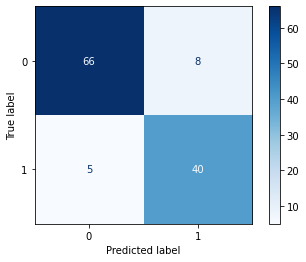

Table 6. Classification Report of SVM Model
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        74
           1       0.83      0.89      0.86        45

    accuracy                           0.89       119
   macro avg       0.88      0.89      0.89       119
weighted avg       0.89      0.89      0.89       119



In [8]:
# Split the data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitting a support vector machine
model = SVC(random_state=0)
print("SVC parameters:", model.get_params())

model.fit(X_train, y_train)


# Compute model predictions
model_predictions = model.predict(X_test)

orig_acc_score_SVM = accuracy_score(y_test, model_predictions)
print("Accuracy:", orig_acc_score_SVM)

# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
print("Figure 3. Confusion Matrix of SVM Model")
plt.show() 
# Print classification report
print("Table 6. Classification Report of SVM Model")
print(classification_report(y_test, model_predictions))

Given the confusion matrix and classification report of the support vector machine, SVC, with default parameters, we observe that this has an accuracy of 0.89.

### Computing Cross-Validated Metrics
We cross validate by calling the cross_val_score helper function on the estimator and the dataset.

We estimate the accuracy of an rbf-kernel support vector machine on the dataset by computing the score 5 consecutive times (with different splits each time):

In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.87341772, 0.88607595, 0.84810127, 0.84810127, 0.81012658])

The mean accuracy score and the standard deviation are hence given by:

In [10]:
orig_acc_score_CV = scores.mean()

print("%0.2f accuracy with a standard deviation of %0.2f" % (orig_acc_score_CV, scores.std()))

0.85 accuracy with a standard deviation of 0.03


Now, we estimate the f1-score of an rbf-kernel support vector machine on the dataset using the same method:

In [11]:
from sklearn import metrics
scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
scores

array([0.87091503, 0.87827427, 0.84072581, 0.84509804, 0.79712378])

The mean f1-score and the standard deviation are hence given by:

In [12]:
orig_acc_F1score_CV = scores.mean()

print("%0.2f accuracy with a standard deviation of %0.2f" % (orig_acc_F1score_CV, scores.std()))

0.85 accuracy with a standard deviation of 0.03


### Training the Support Vector Machine without G1 and G2
As shown in the Correlation Heat Map in Figure 1. Correlation Matrix Heatmap of Student Performance Dataset, attributes G1 and G2 (grade in 1st period and grade in 2nd period) are HIGHLY correlated to the target output, Quality. This may be because Quality is an interpretation of attribute G3 (final grade), and G3 in turn is VERY HIGHLY correlated to G1 and G2, with a correlation level of 0.8 and 0.9, respectively.

Thus, we would like to show below the results of SVM if these 2 attributes are to be removed for analysis. Since the grade attributes will be removed, the basis for prediction shall then be solely demographic attributes and personal profiles of the students, with no involvement of earlier academic performance.

With this, a significant bias in the analysis is removed since it does not consider attributes related to academic performance anymore, which are VERY HIGHLY related with or impactful on the target output, QUALITY.

In [13]:
# Define X and y for testing and training
y = students_math['quality']
# # Drop G3 and Quality, and G1 and G2
X = students_math.drop(['quality', 'G1', 'G2', 'G3'], axis=1)
print(X.shape, y.shape)

(395, 43) (395,)


We set the target column, y, to be the 'quality' column of the students_math dataframe, and set the data, X, to be the students_math dataframe without the columns 'quality', 'G1', 'G2' and 'G3'.

In [14]:
# Compute for the Variance Inflation Factor of each variable to identify
# multicollinearity
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# Compute for the Variance Inflation Factor of each variable
print("Table 7. Variance Inflation Factor of variables of students_math dataframe (w/o G1 and G2)")
calculate_vif(X)

Table 7. Variance Inflation Factor of variables of students_math dataframe (w/o G1 and G2)
<ipython-input-14-74aabace96d7>:10: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1/(1-r_squared),2)


,Var,Vif
42,guardian_other,inf
34,Fjob_services,inf
26,Mjob_at_home,inf
27,Mjob_health,inf
28,Mjob_other,inf
29,Mjob_services,inf
30,Mjob_teacher,inf
31,Fjob_at_home,inf
32,Fjob_health,inf
33,Fjob_other,inf


Similar to the process earlier, we observe that the variance inflation factor of multiple variables are extremely high, some approaching infinity. Thus, there is a presence of multicollinearity which poses a problem as this undermines the statistical significance of supposedly independent variables.

To address multicollinearity within the data, we utilize Principal Component Analysis which employs matrix factorization to reduce the dimensionality of data into lower space that still contains most of the information in the larger set.

Figure 4. Number of components vs. Cumulative explained variance of students_math dataframe (w/o G1 and G2)


Text(0, 0.5, 'cumulative explained variance')

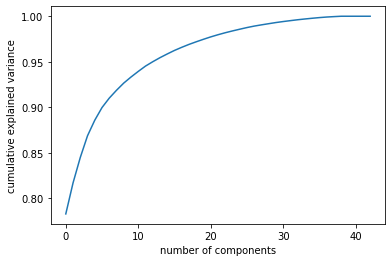

In [15]:
# To address multicollinearity, we utilize Principal Component Analysis.
# Determine the optimal number of components based on the cumulative
# explained variance.
pca = PCA().fit(X)
print("Figure 4. Number of components vs. Cumulative explained variance of students_math dataframe (w/o G1 and G2)")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We observe that at 10 components, the cumulative explained variance already reaches 0.90. Thus, we decided to use 15 components.

In [16]:
# Standardize the data
X = StandardScaler().fit_transform(X)
# PCA Projection
pca = PCA(n_components=15)  
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents)

# Display new dataframe
print("Table 8. students_math dataframe (w/o G1 and G2) after PCA")
display(X)
# Compute for the Variance Inflation Factor of each variable
print("Table 9. Variance Inflation Factor of variables of students_math (w/o G1 and G2) after PCA")
calculate_vif(X)  

Table 8. students_math dataframe (w/o G1 and G2) after PCA


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.696420,-0.543569,-0.830530,2.943415,-0.903290,0.238887,2.663675,0.812153,3.429692,-0.306524,-1.285449,-0.205307,-0.593380,-0.513786,0.621973
1,1.587596,-2.333203,1.025253,1.215612,1.691928,-0.245996,-0.378067,-0.520318,-0.521157,-2.210893,-0.158055,-0.467904,-0.525701,-0.861083,-0.504562
2,1.854501,-0.992269,-0.440001,0.336069,-0.960559,-1.259283,-1.459209,3.490023,0.634674,-0.604033,0.279331,-0.505439,-0.670426,0.632721,0.674713
3,-2.903551,-0.834788,1.208169,-0.289667,-1.000191,-0.526718,-0.165848,1.593953,-1.732435,-0.949278,1.574539,-0.946548,0.446461,-0.205358,-1.109962
4,-0.545183,-1.688027,0.805115,-1.191339,2.276270,0.940360,1.259853,1.096291,-0.458430,-1.033753,-0.581972,-0.373616,1.476181,0.308488,0.324704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,3.638757,3.817039,2.060802,-0.964932,-2.112953,-0.889352,-0.052341,-1.538361,1.506659,-1.209759,-1.899117,2.528774,2.839361,-0.795782,0.504704
391,2.571985,3.255018,-0.277192,1.246593,-0.466258,-0.516077,-0.748857,0.638291,-1.247177,0.921436,-0.571157,1.665683,0.065951,-2.024139,-0.201095
392,6.754430,0.754896,0.699553,-0.992947,0.029601,0.965098,1.181412,-3.206676,0.887722,-0.832699,0.458634,-0.350336,1.597532,0.189892,0.697631
393,3.214061,1.891269,-1.566406,1.671802,0.196696,1.165926,-0.110365,-0.548587,-0.141568,0.912515,-0.576730,1.083460,3.012389,-0.860069,-0.088501


Table 9. Variance Inflation Factor of variables of students_math (w/o G1 and G2) after PCA


,Var,Vif
0,0.0,1.0
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
5,5.0,1.0
6,6.0,1.0
7,7.0,1.0
8,8.0,1.0
9,9.0,1.0


We observe that the variance inflation factor of the principal components are now low (and uniform) at the value 1.0. Thus, there is no more multicollinearity in the data.

We repeat the splitting process and support vector machine implementation before, using a test size of 0.3 for the splitting.

SVC parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Accuracy: 0.5882352941176471
Figure 5. Confusion Matrix of SVM Model (w/o G1 and G2)


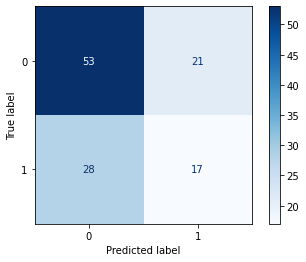

Table 10. Classification Report of SVM Model (w/o G1 and G2)
              precision    recall  f1-score   support

           0       0.65      0.72      0.68        74
           1       0.45      0.38      0.41        45

    accuracy                           0.59       119
   macro avg       0.55      0.55      0.55       119
weighted avg       0.58      0.59      0.58       119



In [17]:
# Split the data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitting a support vector machine
model = SVC(random_state=0)
print("SVC parameters:", model.get_params())

model.fit(X_train, y_train)

# Compute model predictions
model_predictions = model.predict(X_test)

new_acc_score_SVM = accuracy_score(y_test, model_predictions)
print("Accuracy:", new_acc_score_SVM)

# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
print("Figure 5. Confusion Matrix of SVM Model (w/o G1 and G2)")
plt.show() 
# Print classification report
print("Table 10. Classification Report of SVM Model (w/o G1 and G2)")
print(classification_report(y_test, model_predictions))

Given the confusion matrix and classification report of the support vector machine, SVC, with default parameters, we observe that this has an accuracy of 0.59, which is significantly lower than the 0.89 obtained using the SVC fitted with the data with G1 and G2, with default parameters.

### Computing Cross-Validated Metrics
We cross validate by calling the cross_val_score helper function on the estimator and the dataset.

We estimate the accuracy of an rbf-kernel support vector machine on the dataset by computing the score 5 consecutive times (with different splits each time):

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.64556962, 0.69620253, 0.58227848, 0.62025316, 0.5443038 ])

The mean accuracy score and the standard deviation are hence given by:

In [19]:
new_acc_score_CV = scores.mean()

print("%0.2f accuracy with a standard deviation of %0.2f" % (new_acc_score_CV, scores.std()))

0.62 accuracy with a standard deviation of 0.05


Now, we estimate the f1-score of an rbf-kernel support vector machine on the dataset using the same method:

In [20]:
from sklearn import metrics
scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
scores

array([0.64090909, 0.65602322, 0.53153639, 0.56111111, 0.43301435])

The mean f1-score and the standard deviation are hence given by:

In [21]:
new_acc_F1score_CV = scores.mean()

print("%0.2f accuracy with a standard deviation of %0.2f" % (new_acc_F1score_CV, scores.std()))

0.56 accuracy with a standard deviation of 0.08


### Summary of Results

In [22]:
# Displaying the table w/ accuracy scores for comparison <-- REVISE AS GRIDSEARCH IS REMOVED

print("Table 11. Comparison of Accuracy Scores of Variations of the SVM model and the Dataset")

labels = ["SVM", "Cross-Validated SVM", "Difference (SVM - Cross-Validated SVM)"]
d = {'With G1 & G2': [orig_acc_score_SVM, orig_acc_score_CV, orig_acc_score_SVM - orig_acc_score_CV], 
     'Without G1 & G2': [new_acc_score_SVM, new_acc_score_CV, new_acc_score_SVM - new_acc_score_CV], 
     'Difference (with - without)' : [orig_acc_score_SVM - new_acc_score_SVM, orig_acc_score_CV - new_acc_score_CV,
                    (orig_acc_score_SVM - new_acc_score_SVM)-(orig_acc_score_CV - new_acc_score_CV)]}

df = pd.DataFrame(data=d, index=labels)

df

Table 11. Comparison of Accuracy Scores of Variations of the SVM model and the Dataset


,With G1 & G2,Without G1 & G2,Difference (with - without)
SVM,0.890756,0.588235,0.302521
Cross-Validated SVM,0.853165,0.617722,0.235443
Difference (SVM - Cross-Validated SVM),0.037592,-0.029486,0.067078


Table 11 above shows the summary of accuracy scores obtained using different variations of the SVM model and the dataset. In general, it can be seen that the accuracy scores produced by the analysis of the dataset WITH the attributes G1 & G2 (grade in 1st period and grade in 2nd period) are HIGHER than the accurracy scores produced by analysis of the dataset WITHOUT the attributes G1 & G2. 

As shown, the accuracy score produced by default SVM using the dataset WITH G1 & G2 is 0.890756 or 89.0756%, while the accuracy score produced by default SVM using the dataset WITHOUT G1 & G2 is 0.588235	 or 58.8235%. The difference between the two accuracy scores is 0.302521 or 30.2521%, implying that there is a 30.2521% decrease in the accuracy score when G1 & G2 are removed and default SVM is employed. 

When cross validation is performed with SVM, the accuracy score that results from the analaysis of the dataset WITH G1 & G2 is 0.853165 or 85.3165%, whereas the accuracy score that results from the analaysis of the dataset WITHOUT G1 & G2 is 0.617722 or 61.7722%. The difference between the two accuracy scores is 0.235443 or 23.5443%, implying that there is a 23.5443% decrease in the accuracy score when G1 & G2 are removed and cross validation in SVM is employed. 

It can be seen that when cross validation is performed in SVM, there is a lower discrepancy between the accuracy scores produced by the analysis of the dataset WITH the attributes G1 & G2 and the accurracy scores produced by analysis of the dataset WITHOUT the attributes G1 & G2. 

The differences between the accuracy scores in default SVM and cross-validated SVM are 30.2521% and 23.5443% respectively. Thus, there is an average of 26.8982% decrease in the accuracy score when G1 & G2 are removed from the datasets as attributes.

From Table 11 it can also be seen that, using the dataset with G1 & G2, the raw accuracy score from default SVM is HIGHER than the accuracy score from cross-validated SVM, with accuracy scores of 89.0756% and 85.3165% respectively. There is a 3.7592% difference between the two accuracy scores. 	

Using the dataset WITHOUT G1 & G2, the case is the other way around. The raw accuracy score from default SVM is LOWER than the accuracy score from cross-validated SVM, with accuracy scores of 58.8235% and 61.7722% respectively. There is a 2.9486%	difference between the two accuracy scores. 	

These two differences yields an average of 3.5395% difference. Hence, there is no significant difference between the accuracy scores obtained from default SVM and cross-validated SVM. 

In [23]:
# Displaying the table w/ accuracy scores and F1 scores for comparison

print("Table 12. Comparison of Accuracy Scores and F1 Scores From Cross Validation")

labels = ["Accuracy Score", "F1 Score", "Difference (Accuracy - F1)"]
d = {'With G1 & G2': [orig_acc_score_CV, orig_acc_F1score_CV, orig_acc_score_CV - orig_acc_F1score_CV], 
     'Without G1 & G2': [new_acc_score_CV, new_acc_F1score_CV, new_acc_score_CV - new_acc_F1score_CV]}

#      'Difference (with - without)' : [orig_acc_score_SVM - new_acc_score_SVM, orig_acc_score_CV - new_acc_score_CV,
#                     (orig_acc_score_SVM - new_acc_score_SVM)-(orig_acc_score_CV - new_acc_score_CV)]}

df = pd.DataFrame(data=d, index=labels)

df

Table 12. Comparison of Accuracy Scores and F1 Scores From Cross Validation


,With G1 & G2,Without G1 & G2
Accuracy Score,0.853165,0.617722
F1 Score,0.846427,0.564519
Difference (Accuracy - F1),0.006737,0.053203


Table 12 shows the comparison of accuracy scores and F1 scores from cross validation. Using the dataset with G1 & G2, there is only a 0.6737% difference between the accuracy score and F1 score. Using the dataset WITHOUT G1 & G2, there is only a 5.3203% difference between the accuracy score and F1 score.


## Conclusion
The researchers arrived at the following conclusions:
- The Principal Component Analysis was highly effective in standardizing the dataset and addressing multicollinearity in the dataset.

- The SVM model that was trained on the original dataset is highly reliable with an accuracy score of 89.0756% on the set testing data, and a mean accuracy score of 85.3165% and a mean F1-score of 84.6427% after cross-validation. However, the SVM model that was trained on the dataset without the attributes G1 and G2 is not as reliable, with an accuracy score of 58.8235% on the set testing data, and a mean accuracy score of 61.7722% and a mean F1-score of 56.4519% after cross-validation. Furthermore, since the mean accuracy scores and mean F1-scores obtained do not have a huge difference, with only a 0.6737% difference for the SVM model trained on the original dataset and a 5.3203% difference for the SVM model trained on the dataset without G1 & G2. This signals that the samples are well-balanced across the target classes.

- Based on the data and analysis, the raw accuracy scores obtained from the default SVM do not highly differ from the accuracy scores obtained from cross validation, which repeatedly tests the model against unseen data. Thus, the SVM model was able to generalize the dataset well. 

- The attributes G1 & G2 have a very high impact on the target output, Quality since the accuracy scores produced by the SVM trained on the original dataset, i.e. with attributes G1 & G2 (grade in 1st period and grade in 2nd period), are HIGHER than the accurracy scores produced by the SVM trained on the dataset without G1 and G2. This is further supported by the correlation matrix heatmap in Figure 1, which showed that G1 & G2 both have a 76% correlation level with respect to the target output Quality. This is because Quality is an interpretation of attribute G3 (final grade), and G3 in turn is very highly correlated to G1 and G2, with correlation levels of 80% and 90%, respectively. It can be said that Quality is dependent on the two attributes.

## Individual Contributions
Nathaniel Cruel: 

Renzo Virtucio: Authored the Introduction to the Problem and Rationale. Highly contributed to implementing the Principal Component Analysis and training the SVM Models. Provided analysis to the resulting data. Contributed to formulating the Conclusions.